### **Classification of Images (CIFAR-100) using Vision Transformer (ViT)**

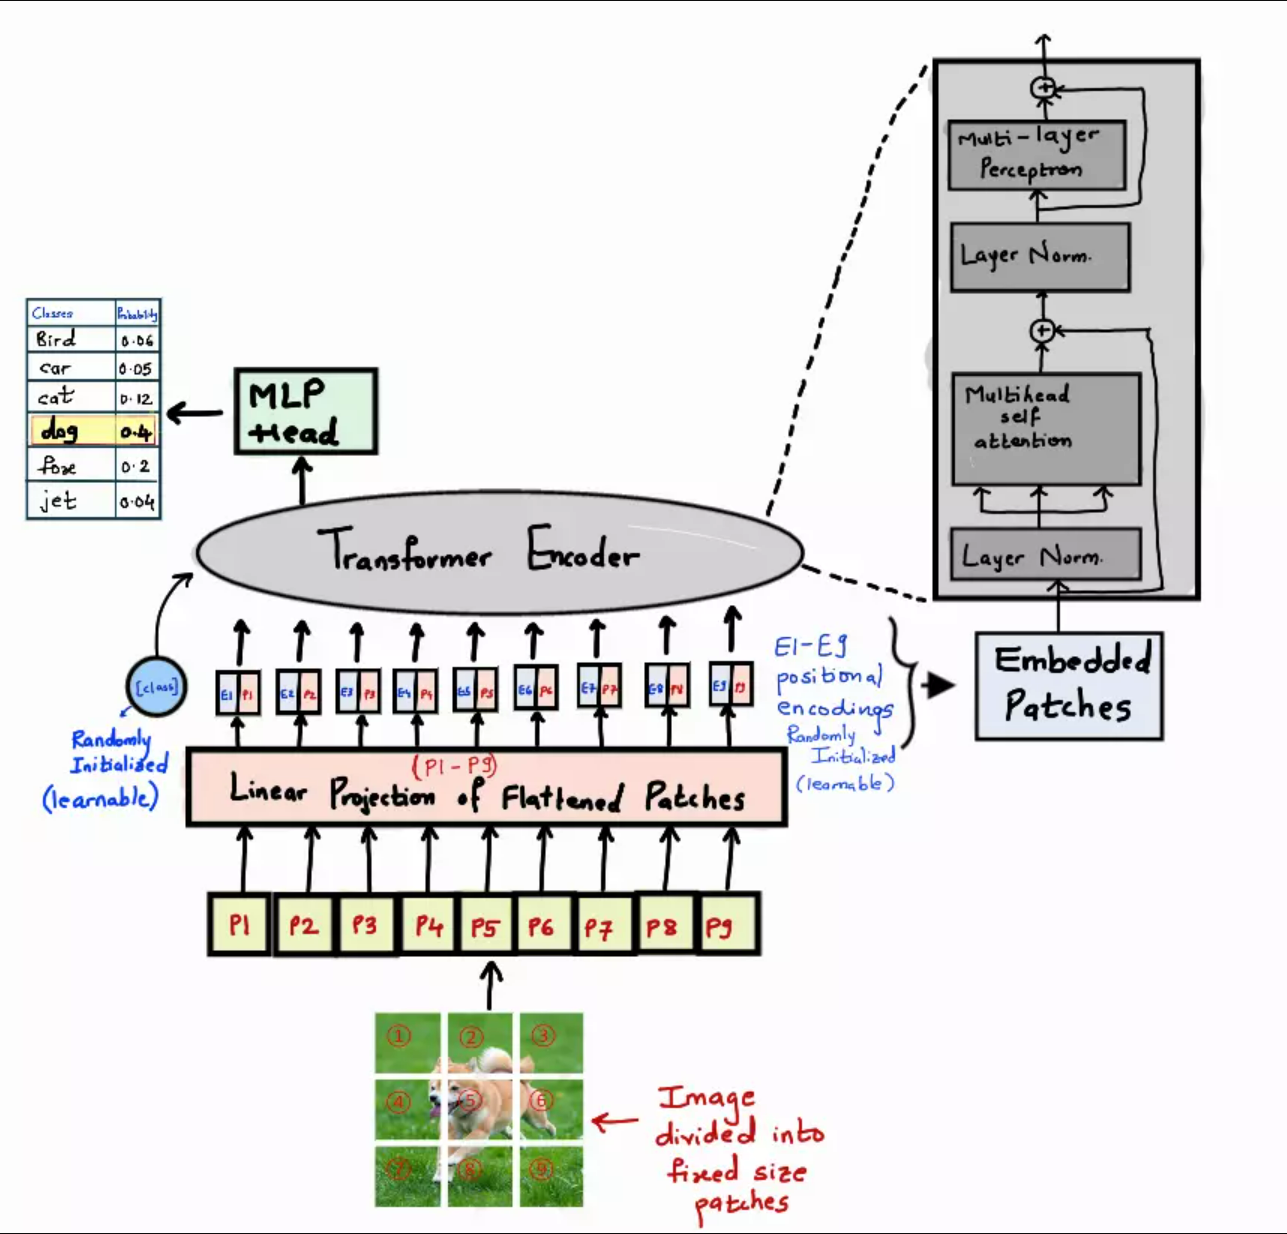

The intuition behind multi-head attention is that it allows us to attend to different parts of the sequence differently each time. This practically means that:


*   The model can better capture positional information because each head will attend to different input segments. The combination of them will give us a more robust representation.
*   
Each head will also capture different contextual information by uniquely correlating words.




In [1]:
pip install -U tensorflow-addons

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## **Load Dataset**

In [3]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [4]:
y_test

array([[49],
       [33],
       [72],
       ...,
       [51],
       [42],
       [70]])

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 1
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [6]:
num_patches

144

## **Use data augmentation**

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)  # layer[0] means for Normalization

## **Implement multilayer perceptron (MLP)**

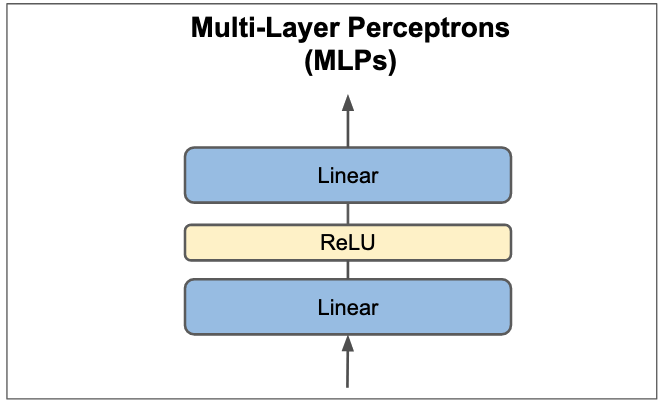

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# **Implement patch creating layer**

In [9]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],  #this will divide the image of  shape 72x72 into 144 patches of shape 6x6.
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        patch_dims = patches.shape[-1]
        print("patch_dims",patch_dims)
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        '''the patches are already flattened'''
        return patches   # the returned patches s of shape (144x108) --> 108 since 3 channel image ==> (6X6X3)

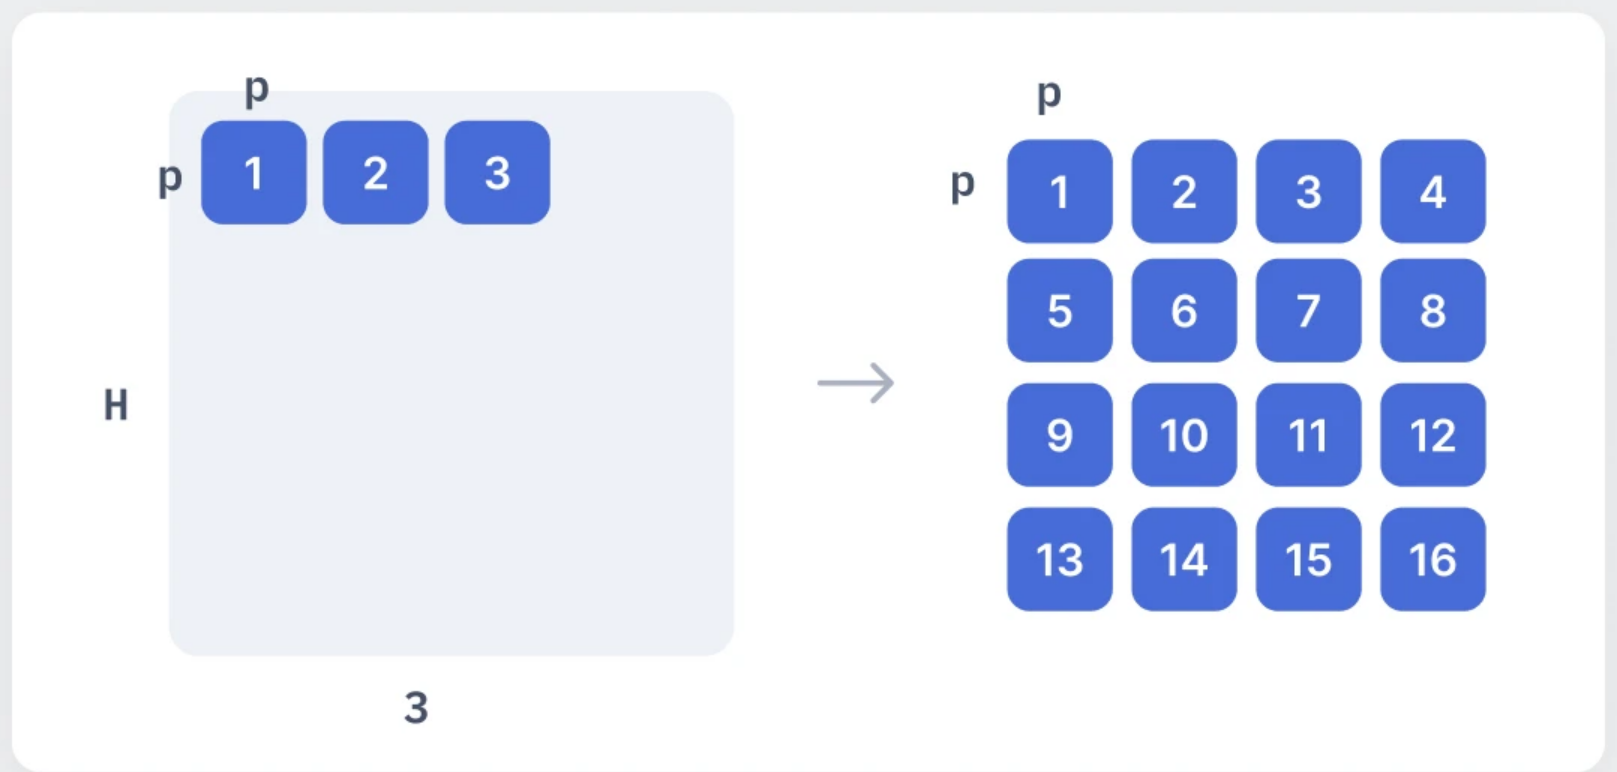

Displaying the patches

patch_dims 108
patches dimension (1, 144, 108)
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


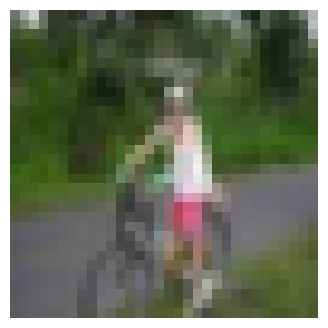

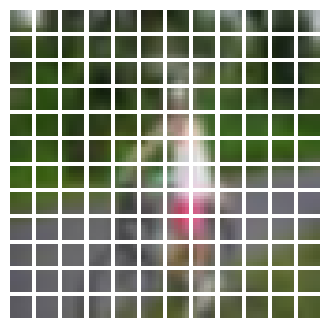

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print("patches dimension",patches.shape)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## **Embedding layer (position and image embeddings)**

The image is converted to square patches.

These patches are flattened and sent through a single Feed Forward layer to get a linear patch projection. This Feed Forward layer contains the embedding matrix E mentioned in the paper. This matrix E is randomly generated.

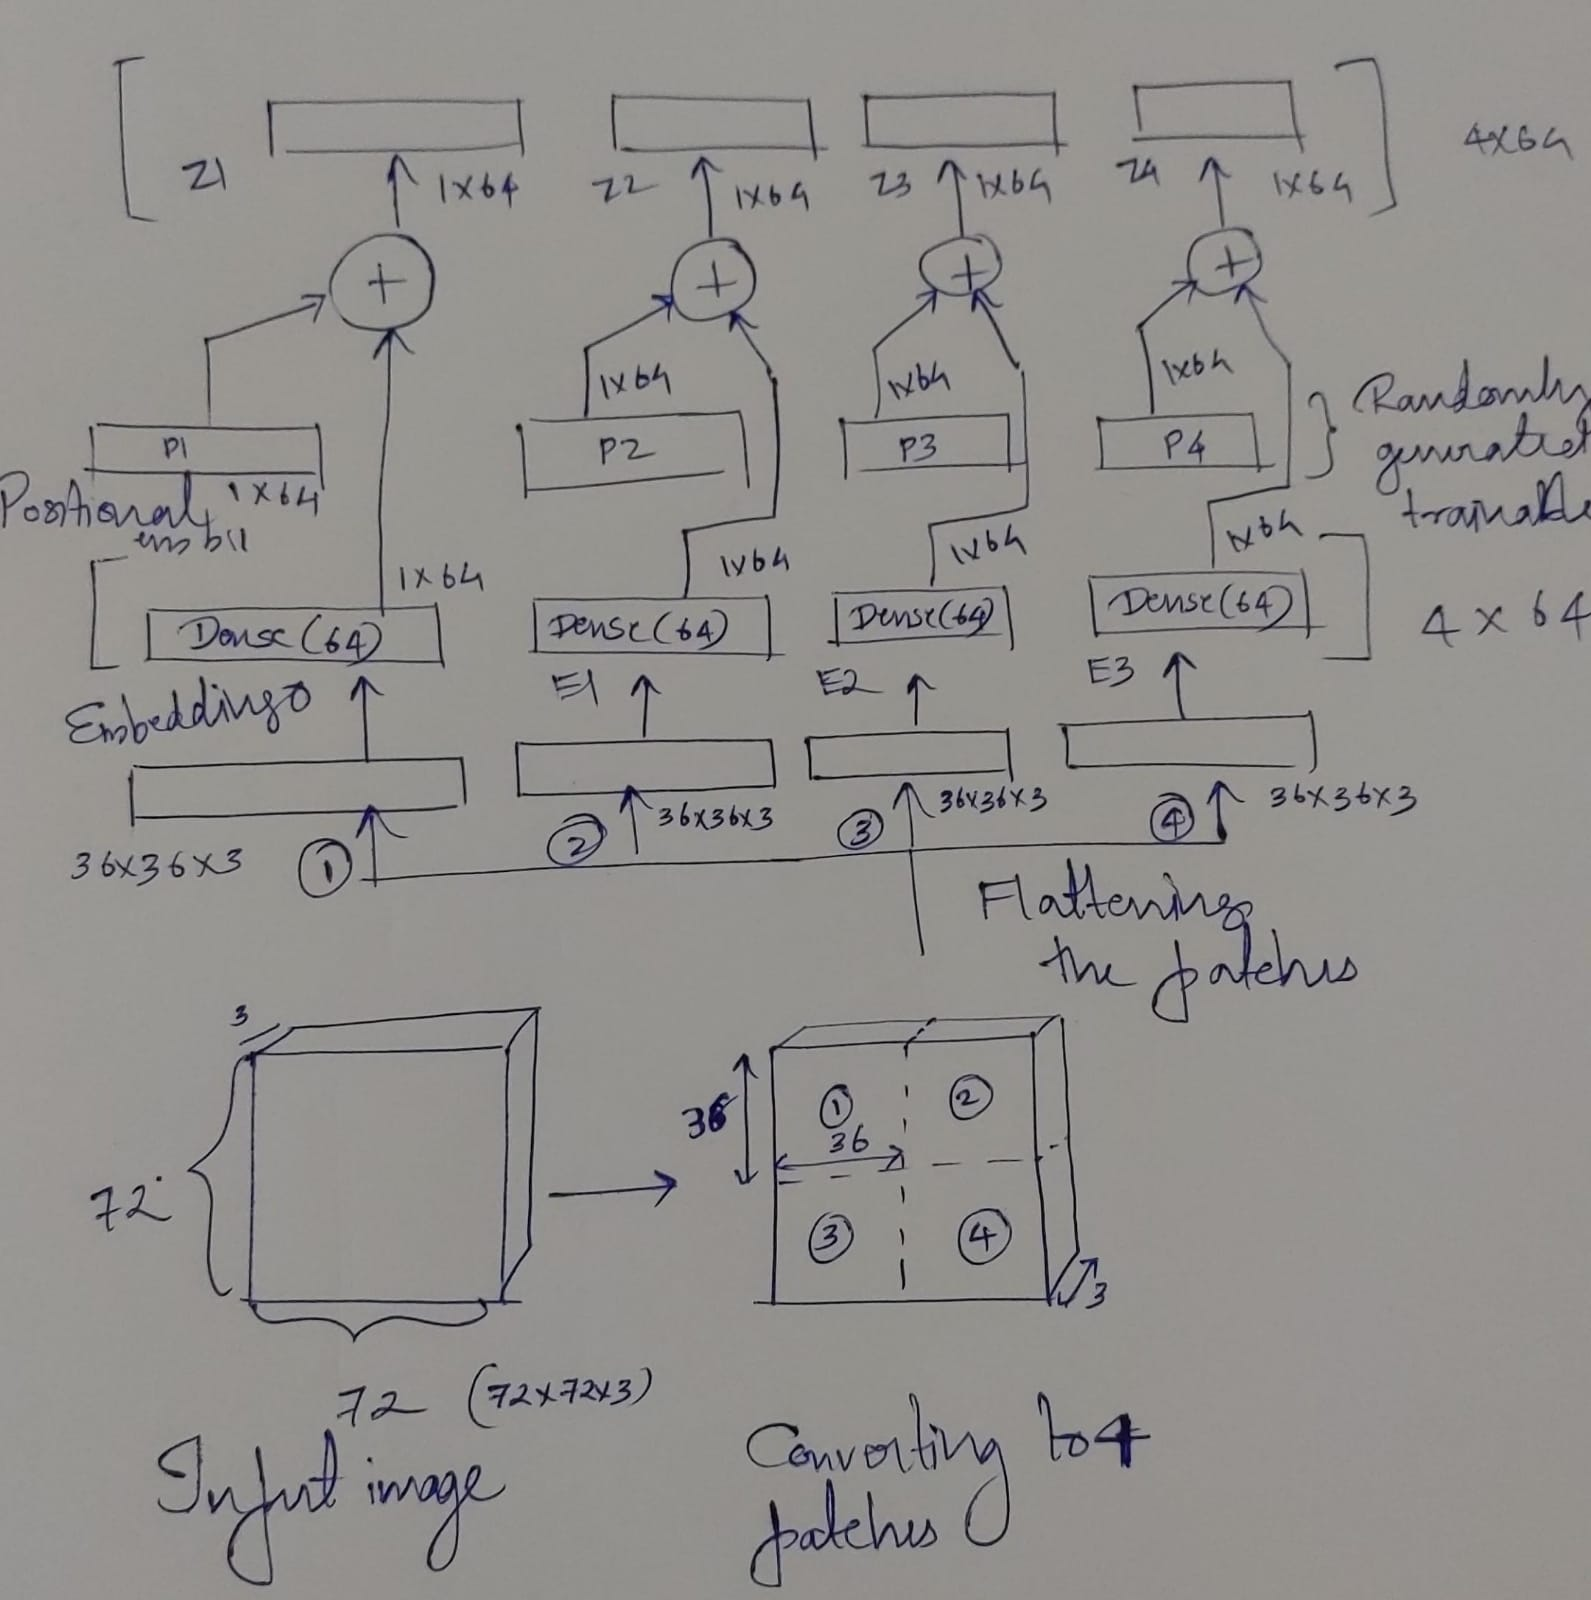

In [11]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):  #144,64
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        '''In the case of orig transformers, "input_dim=num_patches" which means
         Embedding layer should be able to generate word embeddings for all unique words in the vocabulary.
         Since it need to create unique values for each tokens as embeddings, the total number should be known berore hand'''
        # Here input_dim=num_patches, which menas Embedding layer should be able to generate embeddings for all pathces in the vocabulary.
        # input_dim=num_patches, output_dim=projection_dim, projection_dim is similar to embedding dimension in orig transformer.
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        print("patch dim ",patch.shape )
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        print("self.projection(patch) dim",self.projection(patch).shape )
        print("self.position_embedding(positions) dim",self.position_embedding(positions).shape )
        print("encoded dim",encoded.shape )
        return encoded

In [12]:
# num_patches = 4  # Number of patches
# projection_dim = 64  # Dimensionality of the projection

# # Create an instance of the PatchEncoder
# patch_encoder = PatchEncoder(num_patches, projection_dim)

# # Generate example patch data (you would use your actual patch data here)
# batch_size = 1  # You may specify your desired batch size
# patch_data = tf.random.normal((batch_size, num_patches, projection_dim))

# encoded_patches = patch_encoder(patch_data)

In [13]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## **Compile, train, and evaluate the mode**

In [14]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
plot_model(vit_classifier, to_file='vit_classifier.png', show_shapes=True)
history = run_experiment(vit_classifier)

patch_dims 108
patch dim  (None, None, 108)
self.projection(patch) dim (None, None, 64)
self.position_embedding(positions) dim (144, 64)
encoded dim (None, 144, 64)
patch_dims 108
patch dim  (None, None, 108)
self.projection(patch) dim (None, None, 64)
self.position_embedding(positions) dim (144, 64)
encoded dim (None, 144, 64)
patch_dims 108
patch dim  (None, None, 108)
self.projection(patch) dim (None, None, 64)
self.position_embedding(positions) dim (144, 64)
encoded dim (None, 144, 64)
176/176 [==============================] - ETA: 0s - loss: 4.4971 - accuracy: 0.0435 - top-5-accuracy: 0.1555patch_dims 108
patch dim  (None, None, 108)
self.projection(patch) dim (None, None, 64)
self.position_embedding(positions) dim (144, 64)
encoded dim (None, 144, 64)
313/313 [==============================] - 8s 25ms/step - loss: 3.9286 - accuracy: 0.1054 - top-5-accuracy: 0.3153
Test accuracy: 10.54%
Test top 5 accuracy: 31.53%


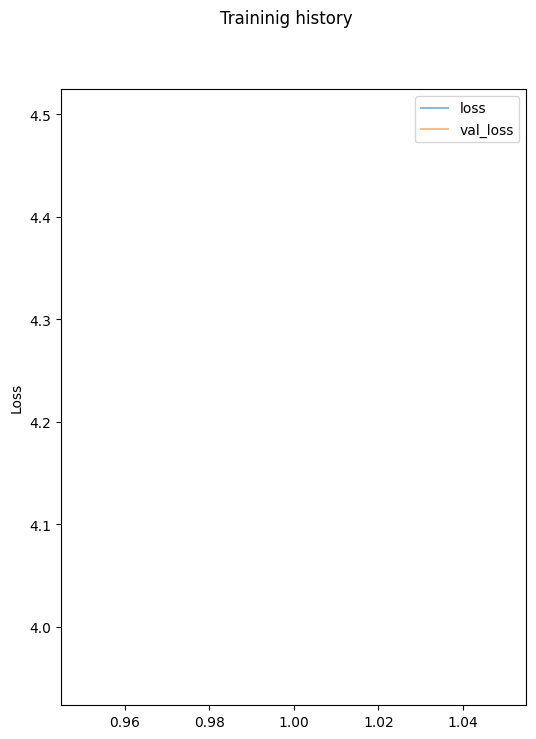

In [15]:
# Plot the loss and accuracy history
fig, axs = plt.subplots(1, figsize=(6, 8), sharex=True)
fig.suptitle('Traininig history')
x = list(range(1, num_epochs+1))
axs.plot(x, history.history["loss"], alpha=0.5, label="loss")
axs.plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs.set_ylabel("Loss")
axs.legend(loc="upper right")
plt.show()